## Lab 3 - Basic Artificial Neural Network

In this lab we will build a very rudimentary Artificial Neural Network (ANN) and use it to solve some basic classification problems. This example is implemented with only basic math and linear algebra functions using Python's scientific computing library [numpy](http://www.numpy.org/). This will allow us to study how each aspect of the network works, and to gain an intuitive understanding of its functions. In future labs we will use higher-level libraries such as Keras and Tensorflow which automate and optimize most of these functions, making the network much faster and easier to use.

The code and MNIST test data is taken directly from [http://neuralnetworksanddeeplearning.com/](http://neuralnetworksanddeeplearning.com/) by [Michael Nielsen](http://michaelnielsen.org/). Please review the [first chapter](http://neuralnetworksanddeeplearning.com/chap1.html) of the book for a thorough explanation of the code.

First we import the Python libraries we will be using, including the random library for generating random numbers, numpy for scientific computing, matplotlib and seaborn for creating data visualizations, and several helpful modules from the sci-kit learn machine learning library:

In [3]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

Next, we will build the artificial neural network by defining a new class called `Network`. This class will contain all the data for our neural network, as well as all the methods we need to compute activations between each layer, and train the network through backpropagation and stochastic gradient descent (SGD).

In [4]:
class Network(object):
    
    def __init__(self, sizes):
        
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs for later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward (self, a):
        
        """Return the output of the network if "a" is input. The np.dot() 
        function computes the matrix multiplication between the weight and input
        matrices for each set of layers. When used with numpy arrays, the '+'
        operator performs matrix addition."""
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters specify the number 
        of epochs, size of each mini-batch, and the learning rate.  
        If "test_data" is provided then the network will be evaluated 
        against the test data after each epoch, and partial progress 
        printed out.  This is useful for tracking progress, but slows
        things down substantially."""
        
        # create an empty array to store the accuracy results from each epoch
        results = []

        n = len(training_data)
        
        if test_data: 
            n_test = len(test_data)
            
        # this is the code for one training step, done once for each epoch
        for j in xrange(epochs):
            
            # before each epoch, the data is randomly shuffled
            random.shuffle(training_data)
            
            # training data is broken up into individual mini-batches
            mini_batches = [ training_data[k:k+mini_batch_size] 
                            for k in xrange(0, n, mini_batch_size) ]
            
            # then each mini-batch is used to update the parameters of the 
            # network using backpropagation and the specified learning rate
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            # if a test data set is provided, the accuracy results 
            # are displayed and stored in the 'results' array
            if test_data:
                num_correct = self.evaluate(test_data)
                accuracy = "%.2f" % (100 * (float(num_correct) / n_test))
                print "Epoch", j, ":", num_correct, "/", n_test, "-", accuracy, "% acc"
                results.append(accuracy)
            else:
                print "Epoch", j, "complete"
                
        return results
    
    def update_mini_batch(self, mini_batch, eta):
        
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The "mini_batch" is a list of tuples "(x, y)", and "eta"
        is the learning rate."""

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        """Note that the variable l in the loop below is used a little
        differently to the notation in Chapter 2 of the book.  Here,
        l = 1 means the last layer of neurons, l = 2 is the
        second-last layer, and so on.  It's a renumbering of the
        scheme in the book, used here to take advantage of the fact
        that Python can use negative indices in lists."""
        
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation.
        
        Numpy's argmax() function returns the position of the 
        largest element in an array. We first create a list of 
        predicted value and target value pairs, and then count 
        the number of times those values match to get the total 
        number correct."""
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

Finally, we define two helper functions which compute the sigmoid activation function and it's derivative which is used in backpropagation.

In [5]:
def sigmoid(z):
#     The sigmoid activation function.
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
#     Derivative of the sigmoid function.
    return sigmoid(z)*(1-sigmoid(z))

### Iris dataset example

Now we will test our basic artificial neural network on a very simple classification problem. First we will use the [seaborn data visualization library](https://stanford.edu/~mwaskom/software/seaborn/) to load the ['iris' dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), 
which consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor), with four features measuring the length and the width of each flower's sepals and petals. After we load the data we will vizualize it using a pairwise plot using a buit-in function in seaborn. A pairwise plot is a kind of exploratory data analysis that helps us to find relationships between pairs of features within a multi-dimensional data set. In this case, we can use it to understand which features might be most useful for determining the species of the flower.

     sepal_length  sepal_width  petal_length  petal_width     species
139           6.9          3.1           5.4          2.1   virginica
19            5.1          3.8           1.5          0.3      setosa
1             4.9          3.0           1.4          0.2      setosa
90            5.5          2.6           4.4          1.2  versicolor
140           6.7          3.1           5.6          2.4   virginica


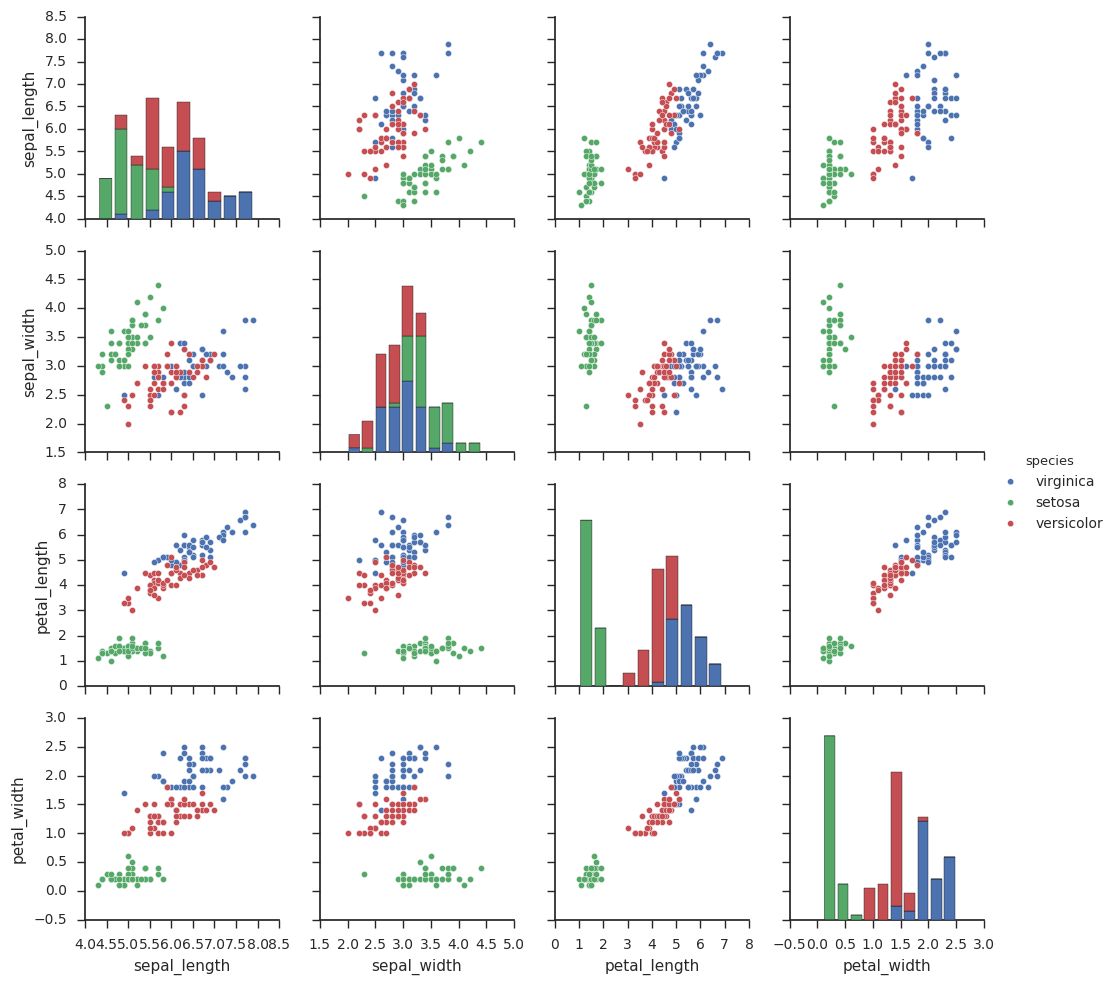

In [6]:
iris_data = sns.load_dataset("iris")

# randomly shuffle data
iris_data = shuffle(iris_data)

# print first 5 data points
print iris_data[:5]

# create pairplot of iris data
g = sns.pairplot(iris_data, hue="species")

Next, we will prepare the data set for training in our ANN. Here is a list of operations we need to perform on the data set so that it will work with the `Network class` we created above:

1. Convert data to numpy format
2. Normalize the data so that each features is scaled from 0 to 1
2. Split data into feature and target data sets by extracting specific rows from the numpy array. In this case the features are in the first four columns, and the target is in the last column, which in Python we can access with a negative index
3. Recombine the data into a single Python array, so that each entry in the array represents one sample, and each sample is composed of two numpy arrays, one for the feature data, and one for the target
4. Split this data set into training and testing sets

Finally, we also need to convert the targets of the training set to 'one-hot' encoding (OHE). OHE takes each piece of categorical data and converts it to a list of binary values the length of which is equal to the number of categories, and the position of the current category denoted with a '1' and '0' for all others. For example, in our dataset we have 3 possible categories: versicolor, virginica, and setosa. After applying OHE, versicolor becomes [1,0,0], virginica becomes [0,1,0], and setosa becomes [0,0,1]. OHE is often used to represent target data in neural networks because it allows easy comparison to the output coming from the network's final layer.

In [7]:
# convert iris data to numpy format
iris_array = iris_data.as_matrix()

# split data into feature and target sets
X = iris_array[:, :4].astype(float)
y = iris_array[:, -1]

# normalize the data per feature by dividing by the maximum value in each column
X = X / X.max(axis=0)

# convert the textual category data to integer using numpy's unique() function
_, y = np.unique(y, return_inverse=True)

# convert the list of targets to a vertical matrix with the dimensions [1 x number of samples]
# this is necessary for later computation
y = y.reshape(-1,1)

# combine feature and target data into a new python array
data = []
for i in range(X.shape[0]):
    data.append(tuple([X[i].reshape(-1,1), y[i][0]]))

# split data into training and test sets
trainingSplit = int(.7 * len(data))
training_data = data[:trainingSplit]
test_data = data[trainingSplit:]

# create an instance of the one-hot encoding function from the sci-kit learn library
enc = OneHotEncoder()

# use the function to figure out how many categories exist in the data
enc.fit(y)

# convert only the target data in the training set to one-hot encoding
training_data = [[_x, enc.transform(_y.reshape(-1,1)).toarray().reshape(-1,1)] for _x, _y in training_data]

Epoch 0 : 18 / 45 - 40.00 % acc
Epoch 1 : 18 / 45 - 40.00 % acc
Epoch 2 : 18 / 45 - 40.00 % acc
Epoch 3 : 18 / 45 - 40.00 % acc
Epoch 4 : 18 / 45 - 40.00 % acc
Epoch 5 : 13 / 45 - 28.89 % acc
Epoch 6 : 14 / 45 - 31.11 % acc
Epoch 7 : 14 / 45 - 31.11 % acc
Epoch 8 : 13 / 45 - 28.89 % acc
Epoch 9 : 13 / 45 - 28.89 % acc
Epoch 10 : 27 / 45 - 60.00 % acc
Epoch 11 : 27 / 45 - 60.00 % acc
Epoch 12 : 27 / 45 - 60.00 % acc
Epoch 13 : 27 / 45 - 60.00 % acc
Epoch 14 : 32 / 45 - 71.11 % acc
Epoch 15 : 27 / 45 - 60.00 % acc
Epoch 16 : 27 / 45 - 60.00 % acc
Epoch 17 : 27 / 45 - 60.00 % acc
Epoch 18 : 27 / 45 - 60.00 % acc
Epoch 19 : 27 / 45 - 60.00 % acc
Epoch 20 : 27 / 45 - 60.00 % acc
Epoch 21 : 27 / 45 - 60.00 % acc
Epoch 22 : 27 / 45 - 60.00 % acc
Epoch 23 : 27 / 45 - 60.00 % acc
Epoch 24 : 27 / 45 - 60.00 % acc
Epoch 25 : 27 / 45 - 60.00 % acc
Epoch 26 : 27 / 45 - 60.00 % acc
Epoch 27 : 27 / 45 - 60.00 % acc
Epoch 28 : 27 / 45 - 60.00 % acc
Epoch 29 : 27 / 45 - 60.00 % acc


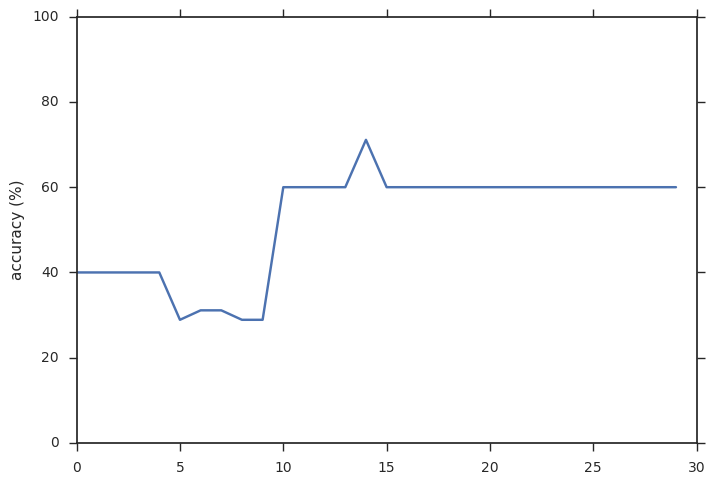

In [8]:
# define the network
net = Network([4, 32, 3])

# train the network using SGD, and output the results
results = net.SGD(training_data, 30, 10, 0.2, test_data=test_data)

# visualize the results
plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()

### MNIST dataset example

Next, we will test our ANN on another, slightly more difficult classification problem. The data set we'll be using is called MNIST, which contains tens of thousands of scanned images of handwritten digits, classified according to the digit type from 0-9. The name MNIST comes from the fact that it is a Modified (M) version of a dataset originally developed by the United States' National Institute of Standards and Technology (NIST). This is a very popular dataset used to measure the effectiveness of Machine Learning models for image recongnition. This time we don't have to do as much data management since the data is already provided in the right format [here](https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master/data). 

We will get into more details about working with images and proper data formats for image data in later labs, but you can already use this data to test the effectiveness of our network. With the default settings you should be able to get a classification accuracy of 95% in the test set.

*note: since this is a much larger data set than the Iris data, the training will take substantially more time.*

In [9]:
import mnist_loader

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

We can use the matplotlib library to visualize one of the training images. In the data set, the pixel values of each 28x28 pixel image is encoded in a straight list of 784 numbers, so before we visualize it we have to use numpy's reshape function to convert it back to a 2d matrix form

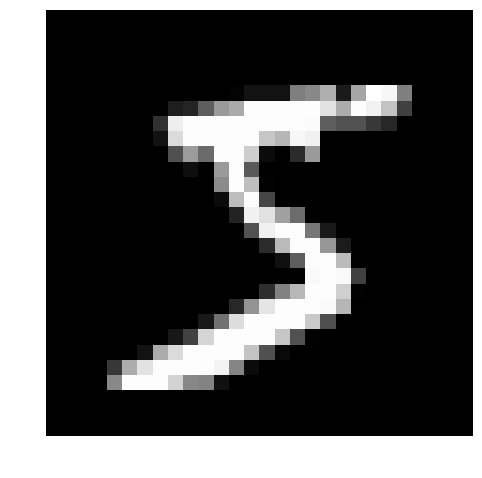

In [10]:
img = training_data[0][0][:,0].reshape((28,28))

fig = plt.figure()
plt.imshow(img, interpolation='nearest', vmin = 0, vmax = 1, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Epoch 0 : 8993 / 10000 - 89.93 % acc
Epoch 1 : 9221 / 10000 - 92.21 % acc
Epoch 2 : 9264 / 10000 - 92.64 % acc
Epoch 3 : 9342 / 10000 - 93.42 % acc
Epoch 4 : 9383 / 10000 - 93.83 % acc
Epoch 5 : 9371 / 10000 - 93.71 % acc
Epoch 6 : 9384 / 10000 - 93.84 % acc
Epoch 7 : 9431 / 10000 - 94.31 % acc
Epoch 8 : 9456 / 10000 - 94.56 % acc
Epoch 9 : 9447 / 10000 - 94.47 % acc
Epoch 10 : 9467 / 10000 - 94.67 % acc
Epoch 11 : 9471 / 10000 - 94.71 % acc
Epoch 12 : 9466 / 10000 - 94.66 % acc
Epoch 13 : 9467 / 10000 - 94.67 % acc
Epoch 14 : 9451 / 10000 - 94.51 % acc
Epoch 15 : 9478 / 10000 - 94.78 % acc
Epoch 16 : 9459 / 10000 - 94.59 % acc
Epoch 17 : 9465 / 10000 - 94.65 % acc
Epoch 18 : 9475 / 10000 - 94.75 % acc
Epoch 19 : 9496 / 10000 - 94.96 % acc
Epoch 20 : 9483 / 10000 - 94.83 % acc
Epoch 21 : 9482 / 10000 - 94.82 % acc
Epoch 22 : 9497 / 10000 - 94.97 % acc
Epoch 23 : 9527 / 10000 - 95.27 % acc
Epoch 24 : 9507 / 10000 - 95.07 % acc
Epoch 25 : 9479 / 10000 - 94.79 % acc
Epoch 26 : 9495 / 1000

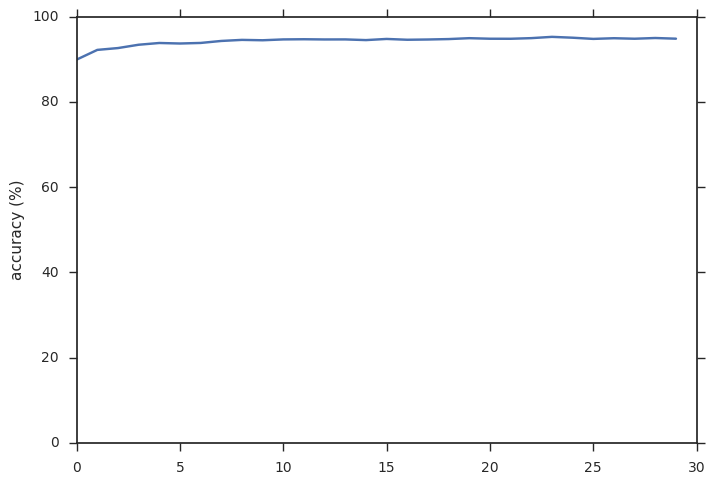

In [11]:
net = Network([784, 30, 10])
results = net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()

## Assignment 3 - classification

Now that you have a basic understanding of how an artificial neural network works and have seen it applied to a classification task using two types of data, see if you can use the network to solve another classification problem using another data set. 

In the week-3 folder there is a data set called `wine.csv` which is another common data set used to test classification capabilities of machine learning algorithms. You can find a description of the data set here:

https://archive.ics.uci.edu/ml/datasets/Wine

The code below uses numpy to import this `.csv` file as a 2d numpy array. As before, we first shuffle the data set, and then split it into feature and target sets. This time, the target is in the first column of the data, with the rest of the columns representing the 13 features. 

From there you should be able to go through and format the data set in a similar way as we did for the Iris data above. Remember to split the data into both training and test sets, and encode the training targets as one-hot vectors. When you create the network, make sure to specify the proper dimensions for the input and output layer so that it matches the number of features and target categories in the data set. You can also experiment with different sizes for the hidden layer. If you are not achieving good results, try changing some of the hyper-parameters, including the size and quantity of hidden layers in the network specification, and the number of epochs, the size of a mini-batch, and the learning rate in the SGD function call. With a training/test split of 80/20 you should be able to achieve 100% accuracy Within 30 epochs.

Remeber to commit your changes and submit a pull request when you are done.

*Hint: do not be fooled by the category labels that come with this data set! Even though the labels are already integers (1,2,3) we need to always make sure that our category labels are sequential integers __and__ start with 0. To make sure this is the case you should always use the np.unique() function on the target data as we did with the Iris example above.*

Epoch 0 : 13 / 36 - 36.11 % acc
Epoch 1 : 11 / 36 - 30.56 % acc
Epoch 2 : 13 / 36 - 36.11 % acc
Epoch 3 : 13 / 36 - 36.11 % acc
Epoch 4 : 11 / 36 - 30.56 % acc
Epoch 5 : 12 / 36 - 33.33 % acc
Epoch 6 : 13 / 36 - 36.11 % acc
Epoch 7 : 11 / 36 - 30.56 % acc
Epoch 8 : 17 / 36 - 47.22 % acc
Epoch 9 : 31 / 36 - 86.11 % acc
Epoch 10 : 30 / 36 - 83.33 % acc
Epoch 11 : 31 / 36 - 86.11 % acc
Epoch 12 : 34 / 36 - 94.44 % acc
Epoch 13 : 35 / 36 - 97.22 % acc
Epoch 14 : 36 / 36 - 100.00 % acc
Epoch 15 : 34 / 36 - 94.44 % acc
Epoch 16 : 35 / 36 - 97.22 % acc
Epoch 17 : 34 / 36 - 94.44 % acc
Epoch 18 : 34 / 36 - 94.44 % acc
Epoch 19 : 33 / 36 - 91.67 % acc
Epoch 20 : 34 / 36 - 94.44 % acc
Epoch 21 : 36 / 36 - 100.00 % acc
Epoch 22 : 34 / 36 - 94.44 % acc
Epoch 23 : 35 / 36 - 97.22 % acc
Epoch 24 : 28 / 36 - 77.78 % acc
Epoch 25 : 34 / 36 - 94.44 % acc
Epoch 26 : 36 / 36 - 100.00 % acc
Epoch 27 : 33 / 36 - 91.67 % acc
Epoch 28 : 34 / 36 - 94.44 % acc
Epoch 29 : 34 / 36 - 94.44 % acc


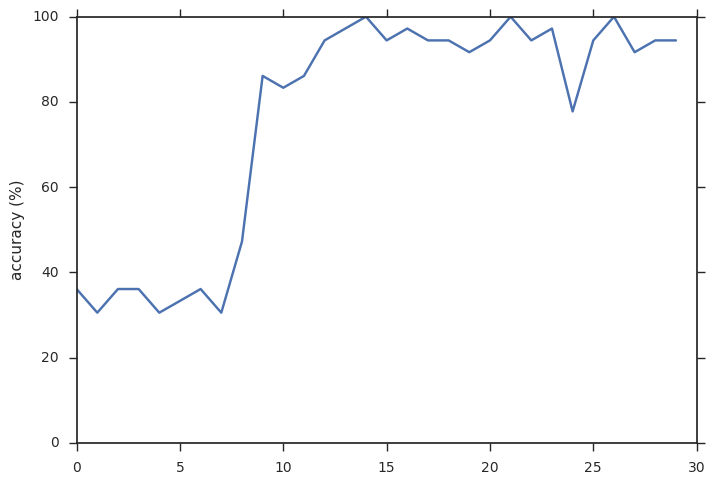

In [38]:
wine_data = np.loadtxt(open("./data/wine.csv","rb"),delimiter=",")

wine_data = shuffle(wine_data)




X = wine_data[:,1:].astype(float)
y = wine_data[:, 0]


X = X / X.max(axis=0)

# convert the textual category data to integer using numpy's unique() function
_, y = np.unique(y, return_inverse=True)

# convert the list of targets to a vertical matrix with the dimensions [1 x number of samples]
# this is necessary for later computation
y = y.reshape(-1,1)

# combine feature and target data into a new python array
data = []
for i in range(X.shape[0]):
    data.append(tuple([X[i].reshape(-1,1), y[i][0]]))

# split data into training and test sets
trainingSplit = int(.8 * len(data))
training_data = data[:trainingSplit]
test_data = data[trainingSplit:]

# create an instance of the one-hot encoding function from the sci-kit learn library
enc = OneHotEncoder()

# use the function to figure out how many categories exist in the data
enc.fit(y)

# convert only the target data in the training set to one-hot encoding
training_data = [[_x, enc.transform(_y.reshape(-1,1)).toarray().reshape(-1,1)] for _x, _y in training_data]
net = Network([13, 100, 3])

# train the network using SGD, and output the results
results = net.SGD(training_data, 30, 10, 0.5, test_data=test_data)

# visualize the results
plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()